In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2DTranspose, Conv2D, InputLayer, UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal

In [8]:
batch_size = 32
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [9]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

seed = 24
tf.random.set_seed(seed)

11490434/11490434 [==============================] - 0s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [10]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [11]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.disc_acc_tracker = keras.metrics.BinaryAccuracy(name="discriminator_accuracy")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Sample random points in the latent space.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Concatenate the real images and fake images with their respective labels
        # for the discriminator input.
        real_image_and_labels = tf.concat([real_images, one_hot_labels], axis=-1)
        fake_image_and_labels = tf.concat([generated_images, one_hot_labels], axis=-1)
        discriminator_input = tf.concat(
            [real_image_and_labels, fake_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        discriminator_labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(discriminator_input)
            d_loss = self.loss_fn(discriminator_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        self.disc_acc_tracker.update_state(discriminator_labels, predictions)

        # Sample new random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images" for the generator.
        generator_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, one_hot_labels], axis=-1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(generator_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )
        self.gen_acc_tracker.update_state(generator_labels, predictions)

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "d_acc": self.disc_acc_tracker.result()
        }


# cDCGAN

In [6]:
generator = Sequential()

generator.add(InputLayer((generator_in_channels,))),
generator.add(Dense(7*7*generator_in_channels, kernel_initializer=RandomNormal(0, 0.02)))
generator.add(LeakyReLU(0.2)) 
generator.add(Reshape((7, 7, generator_in_channels))),
    
generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
generator.add(LeakyReLU(0.2))

generator.add(Conv2D(1, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))

In [7]:
discriminator = Sequential()

discriminator.add(InputLayer((28, 28, discriminator_in_channels))),

discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
discriminator.add(LeakyReLU(0.2))
    
discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
discriminator.add(LeakyReLU(0.2))
    
discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
discriminator.add(LeakyReLU(0.2))
    
discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
discriminator.add(LeakyReLU(0.2))
    
discriminator.add(Flatten())
discriminator.add(Dense(128))
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1))

In [8]:
discriminator.summary()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        6400      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

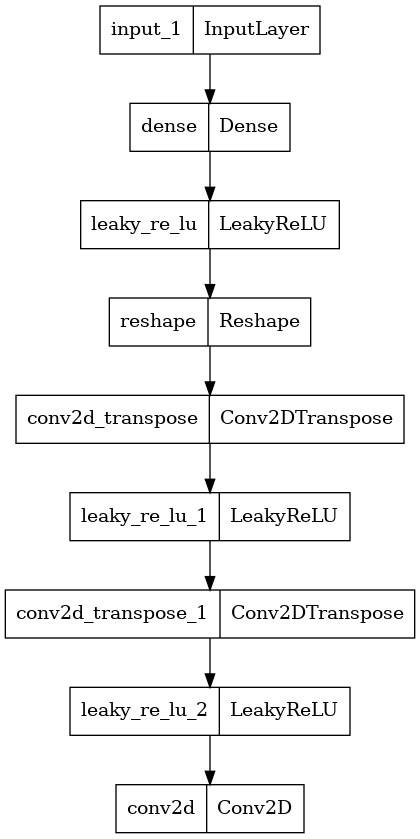

In [9]:
tf.keras.utils.plot_model(generator)

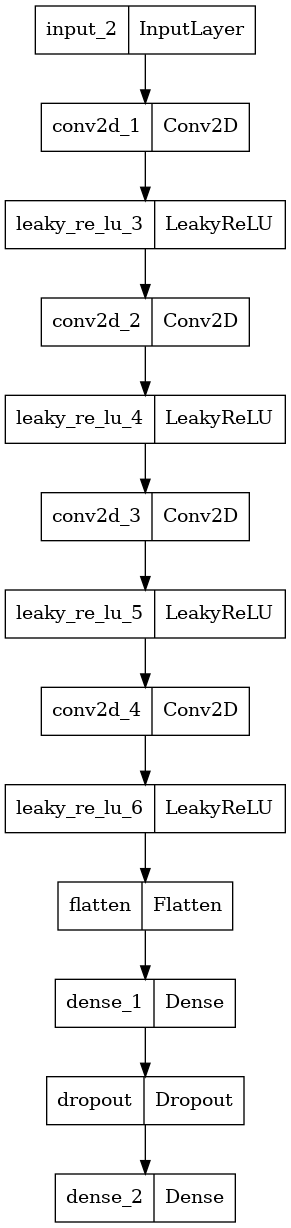

In [10]:
tf.keras.utils.plot_model(discriminator)

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [10]:
cond_gan_history = cond_gan.fit(dataset, epochs=20)

Epoch 1/20
2188/2188 [==============================] - 46s 16ms/step - g_loss: 5.0163 - d_loss: 0.1789 - d_acc: 0.9234
Epoch 2/20
2188/2188 [==============================] - 35s 16ms/step - g_loss: 4.3667 - d_loss: 0.1453 - d_acc: 0.9400
Epoch 3/20
2188/2188 [==============================] - 35s 16ms/step - g_loss: 4.1280 - d_loss: 0.1589 - d_acc: 0.9390
Epoch 4/20
2188/2188 [==============================] - 35s 16ms/step - g_loss: 3.6540 - d_loss: 0.1925 - d_acc: 0.9343
Epoch 5/20
2188/2188 [==============================] - 35s 16ms/step - g_loss: 3.5216 - d_loss: 0.2039 - d_acc: 0.9298
Epoch 6/20
2188/2188 [==============================] - 35s 16ms/step - g_loss: 3.2408 - d_loss: 0.2293 - d_acc: 0.9255
Epoch 7/20
2188/2188 [==============================] - 35s 16ms/step - g_loss: 3.8113 - d_loss: 0.1912 - d_acc: 0.9233
Epoch 8/20
2188/2188 [==============================] - 36s 16ms/step - g_loss: 3.4413 - d_loss: 0.2156 - d_acc: 0.9213
Epoch 9/20
2188/2188 [==================

In [44]:
# Save models to file
generator.save('generator.h5')
discriminator.save('discriminator.h5')

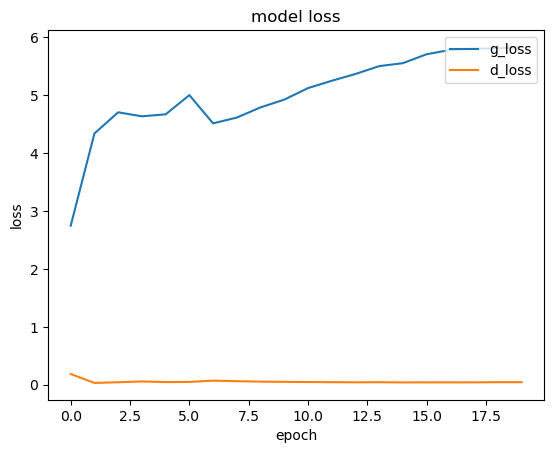

In [11]:
plt.plot(cond_gan_history.history['g_loss'])
plt.plot(cond_gan_history.history['d_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['g_loss', 'd_loss'], loc='upper right')
plt.show()

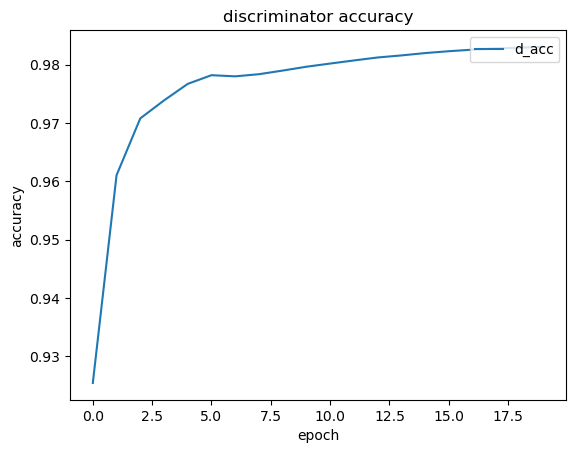

In [12]:
plt.plot(cond_gan_history.history['d_acc'])
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['d_acc'], loc='upper right')
plt.show()

In [12]:
from tensorflow.keras.models import load_model

# Load the saved generator model
generator = load_model('/kaggle/input/cdcgan-saved-model/generator.h5')
discriminator = load_model('/kaggle/input/cdcgan-saved-model/discriminator.h5')
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [13]:

trained_gen = cond_gan.generator

def generate_fake_images(class_number, num_images):
    
    label = keras.utils.to_categorical([class_number], num_classes)
    label = tf.cast(label, tf.float32)
    
    noise = tf.random.normal(shape=(num_images, latent_dim))
    noise_and_labels = tf.concat([noise, tf.repeat(label, num_images, axis=0)], axis=1)
    
    fake_images = trained_gen.predict(noise_and_labels)
    
    return fake_images

1/1 [==============================] - 0s 19ms/step


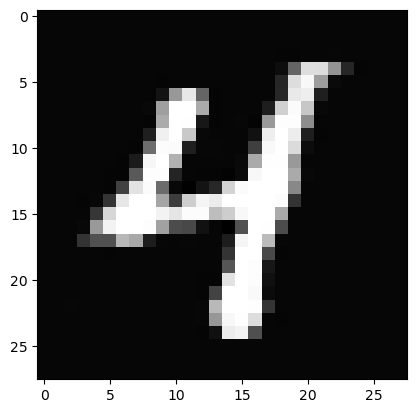

In [32]:
import matplotlib.pyplot as plt

fake_images = generate_fake_images(class_number=4, num_images=1)
plt.imshow(fake_images[0],cmap='gray')
plt.show()

1/1 [==============================] - 0s 19ms/step


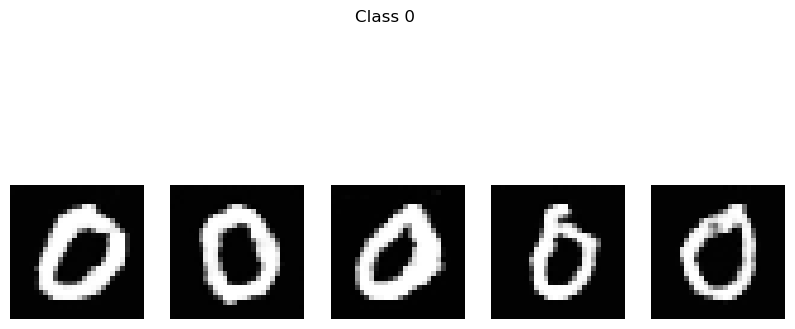

1/1 [==============================] - 0s 19ms/step


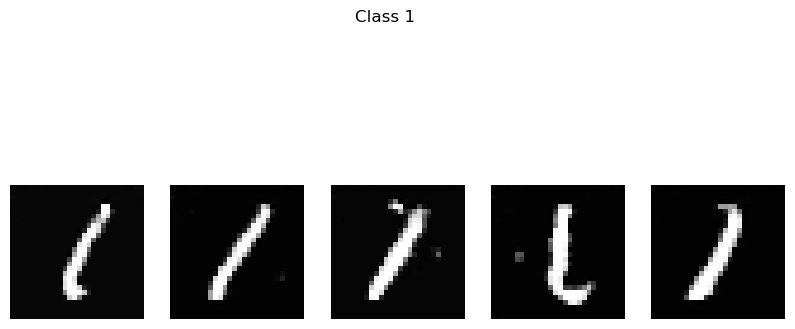

1/1 [==============================] - 0s 19ms/step


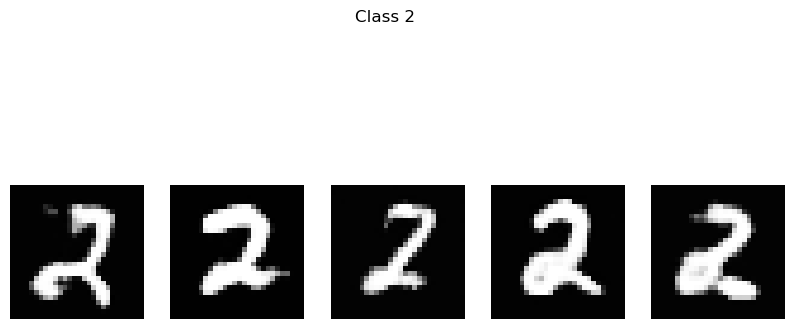

1/1 [==============================] - 0s 20ms/step


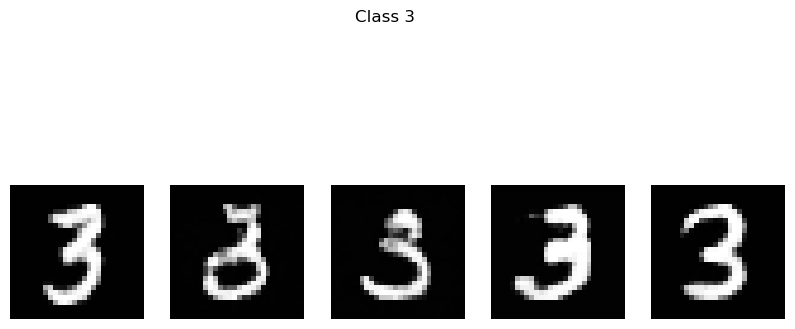

1/1 [==============================] - 0s 20ms/step


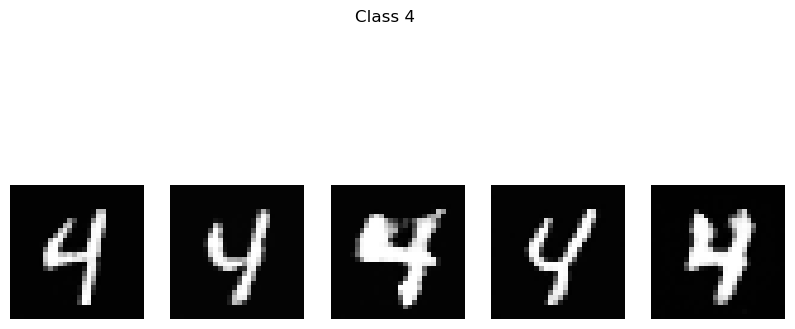

1/1 [==============================] - 0s 19ms/step


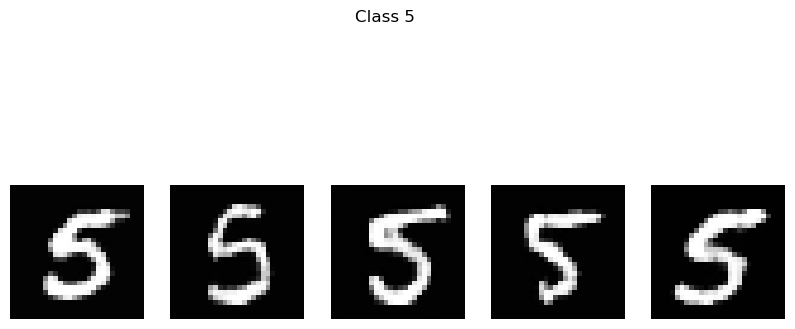

1/1 [==============================] - 0s 20ms/step


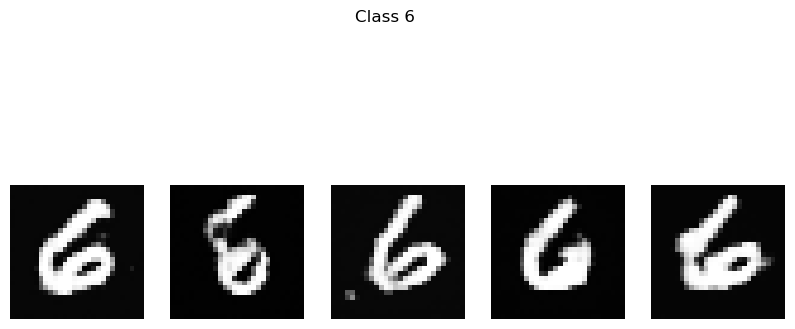

1/1 [==============================] - 0s 19ms/step


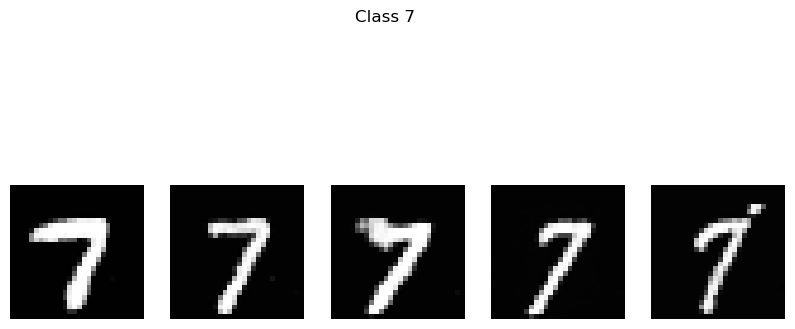

1/1 [==============================] - 0s 19ms/step


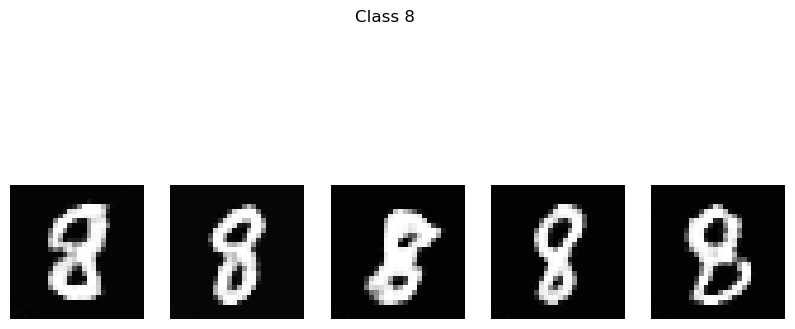

1/1 [==============================] - 0s 18ms/step


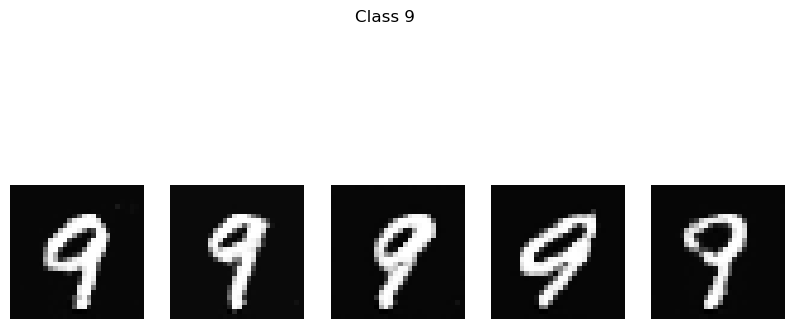

In [15]:
import matplotlib.pyplot as plt

# Define the number of images to generate for each class.
num_images_per_class = 5

# Generate fake images for each class.
for class_number in range(num_classes):
    # Generate fake images for this class.
    fake_images = generate_fake_images(class_number=class_number, num_images=num_images_per_class)
    
    # Plot the generated images in a grid.
    fig, axes = plt.subplots(nrows=1, ncols=num_images_per_class, figsize=(10, 5))
    for i in range(num_images_per_class):
        axes[i].imshow(fake_images[i],cmap="gray")
        axes[i].axis("off")
    plt.suptitle(f"Class {class_number}")
    plt.show()